In [4]:
from web3 import Web3
from dotenv import load_dotenv
import pandas as pd
import os
import json

load_dotenv() 

ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY")

sushi_pool = "0x73DF54500E52343516C0110B4863afaD77423B9C"
univ3_10000 = "0xcDb3a8ade333fB408dB9dCF4326C70b1c3229bB5"
univ3_3000 = "0xFC711972e37f62DC82406b5FF98E68E4fe654E3c"
weth = "0x82aF49447D8a07e3bd95BD0d56f35241523fBab1"
xirtam = "0xe73394F6a157A0Fa656Da2b73BbEDA85c38dfDeC"

block_number = 104254482

w3 = Web3(Web3.HTTPProvider(f'https://arb-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}'))

In [2]:
# ERC-20 ABI
ABI = """[
    {
      "inputs": [
        {
          "internalType": "address",
          "name": "account",
          "type": "address"
        }
      ],
      "name": "balanceOf",
      "outputs": [
        {
          "internalType": "uint256",
          "name": "",
          "type": "uint256"
        }
      ],
      "stateMutability": "view",
      "type": "function"
    }
  ]
"""

abi = json.loads(ABI)
weth = w3.eth.contract(weth, abi=abi)
xirtam = w3.eth.contract(xirtam, abi=abi)

In [57]:
from functools import cache

# Get the balance of the account
@cache
def get_balance(account, contract):
    balance = contract.functions.balanceOf(account).call(block_identifier=block_number)
    return balance

def token_balance(token, pools):
    return [get_balance(pool, token) for pool in pools]

pools = [sushi_pool, univ3_10000, univ3_3000]

d = {"weth": token_balance(weth, pools), "xirtam": token_balance(xirtam, pools)} 
df = pd.DataFrame(data=d, index=["sushi", "univ3_10000", "univ3_3000"])
df

,weth,xirtam
sushi,4535626941606503436,10429409982622639357704757
univ3_10000,201306756420664700,5626335574047118165235195
univ3_3000,15962871013420784,35993101555173304204476


In [58]:
# change xirtam to string
df["xirtam"] = df["xirtam"].astype(str)
df["xirtam"]

sushi          10429409982622639357704757
univ3_10000     5626335574047118165235195
univ3_3000        35993101555173304204476
Name: xirtam, dtype: object

In [59]:
# remove the last 18 digits of xirtam and change it back to int
df["xirtam"] = df["xirtam"].str[:-18]
df["xirtam"] = df["xirtam"].astype(int)
df["xirtam"]

sushi          10429409
univ3_10000     5626335
univ3_3000        35993
Name: xirtam, dtype: int64

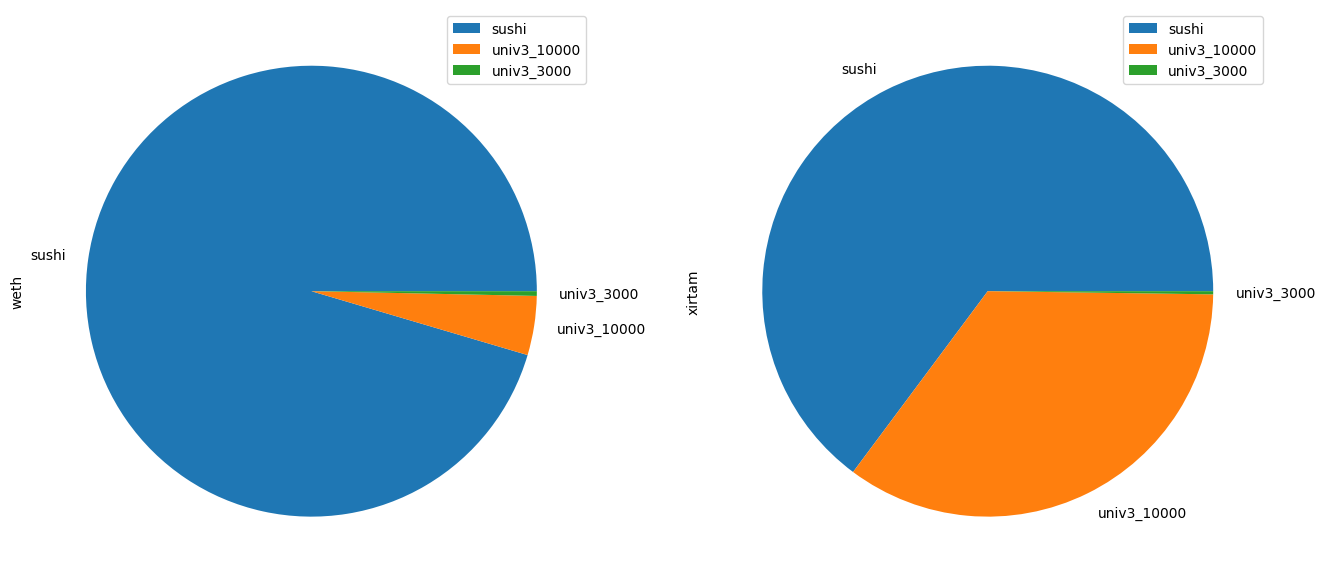

In [61]:
plot = df.plot.pie(subplots=True, figsize=(16, 8))

In [18]:
total_amount_in = 83695536733689272452600
def get_amount_in_for_both_pools(amount_in_on_sushi, amount_out):
	[amount_in_on_sushi, total_amount_in - amount_in_on_sushi, amount_out]

amount_in_on_sushi = [
    58586875713582490716820, 
    66956429386951417962080, 
    74489027692983452482814, 
    75325983060320345207340,
    76162938427657237931866, 
    76999893794994130656392,
    77836849162331023380918,
    78673804529667916105444,
    79510759897004808829970,
    total_amount_in
]
amount_in_on_univ3 = [total_amount_in - amount for amount in amount_in_on_sushi]
index = [70, 80, 89, 90, 91, 92, 93, 94, 95, 100]
amount_out = [34757926684308623, 35040335606271984, 35156444432762078, 35160892502955768, 35163606131712578, 35164573006064752, 35163780692202569, 35161216633989854,35156868151457547, 35107906712239745]
d = {"amount_in_on_sushi": amount_in_on_sushi, "amount_in_on_univ3": amount_in_on_univ3, "amount_out": amount_out}

amounts = pd.DataFrame(data=d, index=index)
amounts

,amount_in_on_sushi,amount_in_on_univ3,amount_out
70,58586875713582490716820,25108661020106781735780,34757926684308623
80,66956429386951417962080,16739107346737854490520,35040335606271984
89,74489027692983452482814,9206509040705819969786,35156444432762078
90,75325983060320345207340,8369553673368927245260,35160892502955768
91,76162938427657237931866,7532598306032034520734,35163606131712578
92,76999893794994130656392,6695642938695141796208,35164573006064752
93,77836849162331023380918,5858687571358249071682,35163780692202569
94,78673804529667916105444,5021732204021356347156,35161216633989854
95,79510759897004808829970,4184776836684463622630,35156868151457547
100,83695536733689272452600,0,35107906712239745


Text(0, 0.5, 'ETH received')

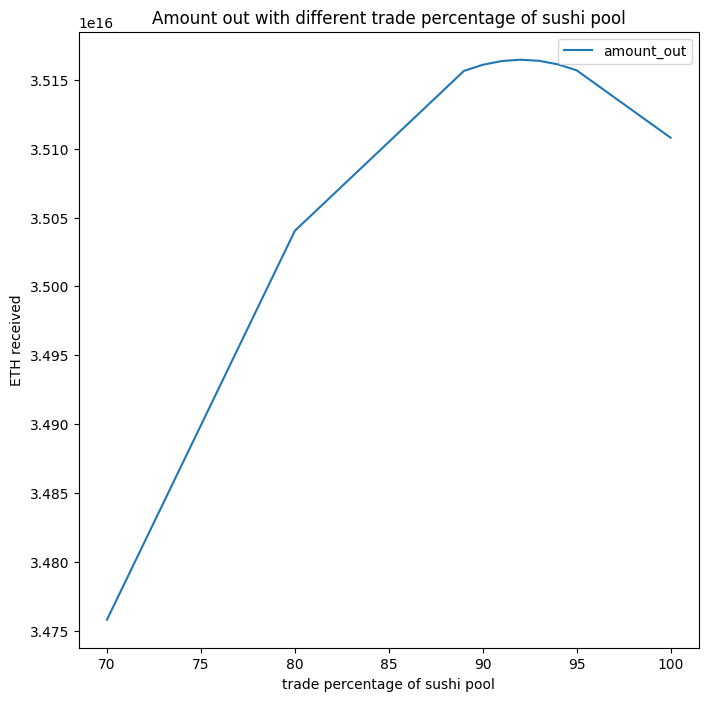

In [40]:
# visualize the data with plot line
plot = amounts.plot.line(figsize=(8, 8))
plot.set_title("Amount out with different trade percentage of sushi pool")
plot.set_xlabel("trade percentage of sushi pool")
plot.set_ylabel("ETH received")


In [38]:
user = [35164573006064752, 21535251082800023]
mev_bot1 = [0, 12276239563244440]
mev_bot2 = [0, 425571747640877]
index = ["ideal trade (sushi 92% & univ3 8%)", "actual trade"]
d = {"user": user, "mev_bot1": mev_bot1, "mev_bot2": mev_bot2}
df = pd.DataFrame(data=d, index=index)
df

,user,mev_bot1,mev_bot2
ideal trade (sushi 92% & univ3 8%),35164573006064752,0,0
actual trade,21535251082800023,12276239563244440,425571747640877


Text(0, 0.5, 'ETH received')

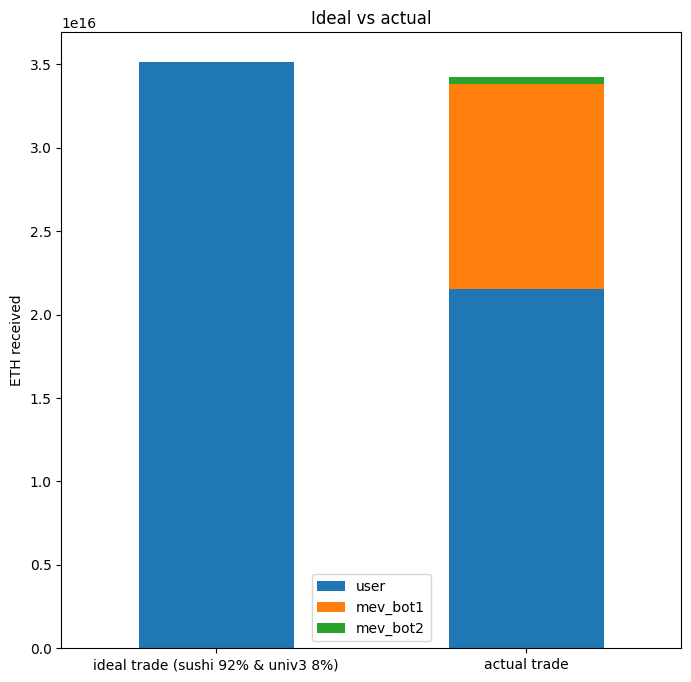

In [42]:
ax = df.plot.bar(rot=0, stacked=True, figsize=(8, 8))
ax.set_title("Ideal vs actual")
ax.set_ylabel("ETH received")